This notebook is the tester for developing a system for recording models in a simplistic method

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [33]:
from lifecycle import database
from lifecycle import models


%load_ext autoreload
%autoreload 2
from lifecycle import database

my_life = models.lifecycle()
mydb = database.lifecycle_db (
    username = 'projectUser',password = 'DCUpassword',
    user='brendan.bonner2@mail.dcu.ie', organisation='Dublin City University',
    lifecycle=my_life)
mydb.init_model_db()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model_vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

model_vgg16_imagenet = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)


model_vgg16_test = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

model_resnet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=500
)


model_resnet50_imagenet = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None
)

In [34]:

signature1, layer_data1 = my_life.create_model_data(model_vgg16)
print(signature1)
signature2, layer_data2 = my_life.create_model_data(model_vgg16_test)
print(signature2)

'''
639f6c10531158279d29f277bce0b7791315b45037069ab4d2952b73a94eeb09
ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f
'''

639f6c10531158279d29f277bce0b7791315b45037069ab4d2952b73a94eeb09
ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f


'\n639f6c10531158279d29f277bce0b7791315b45037069ab4d2952b73a94eeb09\nede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f\n'

In [36]:
# get a signature and write it to the model

local = True
parent = mydb.push_model(model_resnet50,local=local)
last = mydb.push_model(model_resnet50_imagenet,parent=parent,local=local)
print(parent, last)
parent = mydb.push_model(model_vgg16_imagenet,local=local)
last = mydb.push_model(model_vgg16_test, parent=parent,local=local)
print(parent, last)


signature:  dfb42f093ee7cf4dac160cb6c4e33a4b5f86f466db7e953d5a8677dd7f508132  already in database
signature:  11038ddd9667dc41fdda32191266367a344ac28c0dde3bb3f5a86d8c7b67f0b0  already in database
dfb42f093ee7cf4dac160cb6c4e33a4b5f86f466db7e953d5a8677dd7f508132 11038ddd9667dc41fdda32191266367a344ac28c0dde3bb3f5a86d8c7b67f0b0
signature:  ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f  already in database
signature:  ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f  already in database
ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f


In [37]:
# Push all default models from Keras
keras_model_list = {
    'VGG16': tf.keras.applications.VGG16,
    'DenseNet121': tf.keras.applications.DenseNet121,
    'Xception': tf.keras.applications.Xception
}

for name, model_type in enumerate(keras_model_list):
    print(model_type)
    model = keras_model_list[model_type]()
    print(mydb.push_model(model,model_source = model_type, organisation='Keras',local=local))



VGG16
signature:  ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f  already in database
ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f
DenseNet121
signature:  42f9a65180edde3acf9eb4a0ff56659d79e2f7093e62d5a2de315555307b5e96  already in database
42f9a65180edde3acf9eb4a0ff56659d79e2f7093e62d5a2de315555307b5e96
Xception
signature:  bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd  already in database
bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd


In [39]:
xception1 = mydb.get_model_data(signature='bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd')
xception2 = mydb.get_model_data(signature='bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd')

x = xception1['structure']
y = xception2['structure']

shared_items = {k: x[k] for k in x if k in y and x[k] == y[k]}
print (len(shared_items))
unshared_items = {k: x[k] for k in x if k in y and x[k] != y[k]}
print (len(unshared_items))


signatture bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd
signatture bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd
134
0


In [41]:
# Make a small adjustment to test the SHA change
last = mydb.push_model(model_vgg16_test, parent=last, user='brendanboner@gmail.com', local=False)

for x in range(5):
    weights = model_vgg16_test.layers[1].get_weights()
    weights[0][0][0][0] = weights[0][0][0][0] * 1.004
    model_vgg16_test.layers[1].set_weights(weights)
    last = mydb.push_model(model_vgg16_test, parent=last)
    print(last)


signature:  ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f  already in database
f93ad7c257c280ee7bdf2e3ac74166c785174e33d7e43cf066fa91f6c623db42
bfb6f85b578bc1a768c941ca25765af982712ab9a36c23968a73bcc7c3511853
f569e9b42874e1d9c4123ae231cc7629fa92459630fdf6bcd9b1a8e318cb34a9
96130c2c370d9a5719da42d3354aa887db4f1ce8ae2fdb40e04fbad6cd704c26
d5bdacfc8c24d32299dd824118356c0056116130038533efa185a8758a991618


In [43]:
# Get model and write to layer

def show_history(signature):

    print("Getting Signature: ",signature)
    signature_data = mydb.get_model(signature)
    if (signature_data):
        baseline_model_data = mydb.get_model_data(signature_data['model_data'])

        if baseline_model_data == None:
            print ('no model data for : ', signature_data['model_data'])
        else:
            print('Layers: ', len(baseline_model_data['data']))
            print( signature_data['_id'].generation_time, ' : Model Id ', signature_data['model_data'])
            old_data = baseline_model_data['data']

            history = []
            while signature_data['parent'] != None:

                # get model
                signature_data = mydb.get_model(signature_data['parent'])
                print( signature_data['_id'].generation_time, ' : Model Id ', signature_data['model_data'])

                new_model_data = mydb.get_model_data(signature_data['model_data'])
                if new_model_data == None:
                    print ('no model data for : ', signature_data['model_data'])
                else:
                    history_layer = []
                    data = new_model_data['data']
                    for key, value in data.items():
                        if (old_data[key]['weight_std'] == 0):
                            history_layer.append(old_data[key]['weight_std'])
                        else:
                            history_layer.append(
                                value['weight_std']  / old_data[key]['weight_std']
                            )

                    history.append(history_layer)
                    old_data = new_model_data['data']


    

            print(signature_data['username'], signature_data['organisation'])
            print(history)
    else:
        print('signature not found')




show_history('d5bdacfc8c24d32299dd824118356c0056116130038533efa185a8758a991618')

# show_history('c7e952212c1c260c0bba4d0624ef0baad6082470a18aa51798d33ea708874930') # ResNet50

Getting Signature:  d5bdacfc8c24d32299dd824118356c0056116130038533efa185a8758a991618
Layers:  23
2021-08-04 00:38:37+00:00  : Model Id  6109e18dccb38775bdde0a51
2021-08-04 00:38:34+00:00  : Model Id  6109e18accb38775bdde0a4f
2021-08-04 00:38:31+00:00  : Model Id  6109e187ccb38775bdde0a4d
2021-08-04 00:38:28+00:00  : Model Id  6109e184ccb38775bdde0a4b
2021-08-04 00:38:25+00:00  : Model Id  6109e181ccb38775bdde0a49
2021-08-04 00:22:38+00:00  : Model Id  6109ddceccb38775bdde0a41
 
[[0, 0.9998779512789286, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0], [0, 0.9998789451714579, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0], [0, 0.999879795297445, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0], [0, 0.9998807898801996, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0], [0, 0.9998816406565643, 1.0, 0, 1.0, 1.0, 0, 

In [ ]:
def diff_model(model_vgg16, model_resnet50):
    for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
        w1 = l1.get_weights()
        w2 = l2.get_weights()
        if len(w1) > 0:
            wa1 = np.ndarray.flatten(w1[0])
            wa2 = np.ndarray.flatten(w2[0])
            # Weights available
            print(l1.get_config()['name'],
                w1[0].shape,
                np.std(wa1), np.median(wa1),
                w2[0].shape,
                np.std(wa2), np.median(wa2),
                np.std(wa1) == np.std(wa2)
            )
            
        else:
            print(l1.get_config()['name'],len(w1))

In [16]:
#Display a comparison of multiple layers
def get_weights_print_stats(layer):
    W = layer.get_weights()
    if len(W) > 0:
        print(len(W))
        print(W[0].shape)
    return W

def hist_weights(weights, bins=100, label='default'):
    for weight in weights:
        
        plt.hist(np.ndarray.flatten(weight), bins=bins, label=label)

'''
for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
    print(l1.get_config()['name'])
    W = get_weights_print_stats(l1)
    hist_weights(W, label='Model 1')
    W = get_weights_print_stats(l2)
    hist_weights(W, label='Model 2')
    plt.show()
'''

show_all = False

hist_std1 = []
hist_std2 = []
hist_skew1 = []
hist_skew2 = []

for l1, l2 in zip(model_vgg16_imagenet.layers, model_vgg16.layers):

    w1 = l1.get_weights()
    w2 = l2.get_weights()


    if len(w1) > 0:
        # Layers available

        weight1_value   = np.ndarray.flatten(w1[0])
        weight1_skew  = skew(np.ndarray.flatten(w1[0]))
        weight1_std     = np.std(weight1_value).item()
        # print('std1 {:.4f}, skew1 {:.4f}'.format(weight1_std, weight1_skew))
        
        weight2_value   = np.ndarray.flatten(w2[0])
        weight2_skew  = skew(np.ndarray.flatten(w2[0]))
        weight2_std     = np.std(weight2_value).item()
        # print('std2 {:.4f}, skew2 {:.4f}'.format(weight2_std, weight2_skew))

        hist_std1.append(weight1_std)
        hist_std2.append(weight2_std)
        hist_skew1.append(weight1_skew)
        hist_skew2.append(weight2_skew)
        
        if show_all:
            print(l1.get_config()['name'],len(w1), w1[0].shape)
            plt.hist(
                [ np.ndarray.flatten(w1[0]),
                np.ndarray.flatten(w2[0])],
                alpha=0.5, bins=1000, label=['X','Y'])
            plt.legend(loc='upper right')

            plt.show()



std diff : -126595.3922 %
skw diff : 100.0000 %


<function matplotlib.pyplot.show(close=None, block=None)>

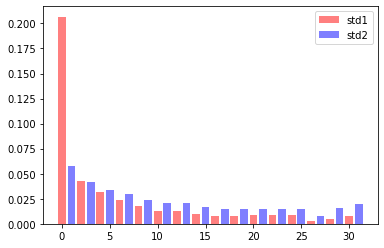

In [ ]:
hist_std = 1
hist_skew = 1
for i,v in enumerate(hist_std1):
    if (v != 0):
        hist_std = (hist_std2[i] / v) * hist_std
    if (hist_skew1[i] != 0):
        hist_skew = (hist_skew2[i] / hist_skew1[i]) * hist_skew

print ('std diff : {:.4f} %'.format((1-hist_std) * 100))
print ('skw diff : {:.4f} %'.format((1-hist_skew) * 100))

layers = len(hist_std1)
plt.bar( np.arange(layers) * 2, hist_std1, color = 'red' , alpha=0.5, label='std1')
plt.bar( np.arange(layers)* 2 + 1, hist_std2, color = 'blue', alpha=0.5, label='std2' )
plt.legend(loc='upper right')

plt.show



16


<function matplotlib.pyplot.show(close=None, block=None)>

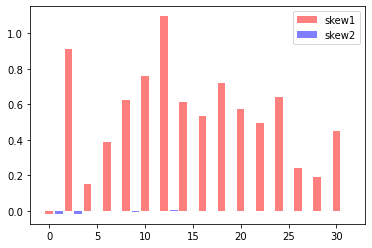

In [ ]:
layers = len(hist_skew1)
print(layers)
plt.bar( np.arange(layers) * 2, hist_skew1, color = 'red' , alpha=0.5, label='skew1')
plt.bar( np.arange(layers)* 2 + 1, hist_skew2, color = 'blue', alpha=0.5, label='skew2' )
plt.legend(loc='upper right')
plt.show